### Will a Customer Accept the Coupon?

**Context**

Imagine driving through town and a coupon is delivered to your cell phone for a restaraunt near where you are driving. Would you accept that coupon and take a short detour to the restaraunt? Would you accept the coupon but use it on a sunbsequent trip? Would you ignore the coupon entirely? What if the coupon was for a bar instead of a restaraunt? What about a coffee house? Would you accept a bar coupon with a minor passenger in the car? What about if it was just you and your partner in the car? Would weather impact the rate of acceptance? What about the time of day?

Obviously, proximity to the business is a factor on whether the coupon is delivered to the driver or not, but what are the factors that determine whether a driver accepts the coupon once it is delivered to them? How would you determine whether a driver is likely to accept a coupon?

**Overview**

The goal of this project is to use what you know about visualizations and probability distributions to distinguish between customers who accepted a driving coupon versus those that did not.

**Data**

This data comes to us from the UCI Machine Learning repository and was collected via a survey on Amazon Mechanical Turk. The survey describes different driving scenarios including the destination, current time, weather, passenger, etc., and then ask the person whether he will accept the coupon if he is the driver. Answers that the user will drive there ‘right away’ or ‘later before the coupon expires’ are labeled as ‘Y = 1’ and answers ‘no, I do not want the coupon’ are labeled as ‘Y = 0’.  There are five different types of coupons -- less expensive restaurants (under \\$20), coffee houses, carry out & take away, bar, and more expensive restaurants (\\$20 - \\$50). 

**Deliverables**

Your final product should be a brief report that highlights the differences between customers who did and did not accept the coupons.  To explore the data you will utilize your knowledge of plotting, statistical summaries, and visualization using Python. You will publish your findings in a public facing github repository as your first portfolio piece. 





### Data Description
Keep in mind that these values mentioned below are average values.

The attributes of this data set include:
1. User attributes
    -  Gender: male, female
    -  Age: below 21, 21 to 25, 26 to 30, etc.
    -  Marital Status: single, married partner, unmarried partner, or widowed
    -  Number of children: 0, 1, or more than 1
    -  Education: high school, bachelors degree, associates degree, or graduate degree
    -  Occupation: architecture & engineering, business & financial, etc.
    -  Annual income: less than \\$12500, \\$12500 - \\$24999, \\$25000 - \\$37499, etc.
    -  Number of times that he/she goes to a bar: 0, less than 1, 1 to 3, 4 to 8 or greater than 8
    -  Number of times that he/she buys takeaway food: 0, less than 1, 1 to 3, 4 to 8 or greater
    than 8
    -  Number of times that he/she goes to a coffee house: 0, less than 1, 1 to 3, 4 to 8 or
    greater than 8
    -  Number of times that he/she eats at a restaurant with average expense less than \\$20 per
    person: 0, less than 1, 1 to 3, 4 to 8 or greater than 8
    -  Number of times that he/she goes to a bar: 0, less than 1, 1 to 3, 4 to 8 or greater than 8
    

2. Contextual attributes
    - Driving destination: home, work, or no urgent destination
    - Location of user, coupon and destination: we provide a map to show the geographical
    location of the user, destination, and the venue, and we mark the distance between each
    two places with time of driving. The user can see whether the venue is in the same
    direction as the destination.
    - Weather: sunny, rainy, or snowy
    - Temperature: 30F, 55F, or 80F
    - Time: 10AM, 2PM, or 6PM
    - Passenger: alone, partner, kid(s), or friend(s)


3. Coupon attributes
    - time before it expires: 2 hours or one day

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

### Problems

Use the prompts below to get started with your data analysis.  

#### 1. Read in the `coupons.csv` file.




In [2]:
data = pd.read_csv('data/coupons.csv')

In [3]:
data.head(2)

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0


#### 2. Investigate the dataset for missing or problematic data.

In [4]:
print('Dimensions of data read in (rows x columns): {}'.format(data.shape))

Dimensions of data read in (rows x columns): (12684, 26)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

**%Completeness of each column - is there any missing data?**

In [6]:
data.isnull().sum().transform(lambda x: (1 - (x / data.shape[0])) * 100)

destination             100.000000
passanger               100.000000
weather                 100.000000
temperature             100.000000
time                    100.000000
coupon                  100.000000
expiration              100.000000
gender                  100.000000
age                     100.000000
maritalStatus           100.000000
has_children            100.000000
education               100.000000
occupation              100.000000
income                  100.000000
car                       0.851466
Bar                      99.156418
CoffeeHouse              98.289183
CarryAway                98.809524
RestaurantLessThan20     98.975087
Restaurant20To50         98.509934
toCoupon_GEQ5min        100.000000
toCoupon_GEQ15min       100.000000
toCoupon_GEQ25min       100.000000
direction_same          100.000000
direction_opp           100.000000
Y                       100.000000
dtype: float64

In [7]:
data.car.value_counts()

car
Scooter and motorcycle                      22
Mazda5                                      22
do not drive                                22
crossover                                   21
Car that is too old to install Onstar :D    21
Name: count, dtype: int64

#### 3. Decide what to do about your missing data -- drop, replace, other...

* Drop car column: only 0.85% rows have values
* Keep the rest of the columns - above 98% have non-null data

In [8]:
car_nulls = data.car.isnull().sum()
data = data.drop(labels=('car'), axis=1)
print('Dropped column \'car\' as {} of {} rows are null - only {:.2f}% useful rows!'
      .format(car_nulls, data.shape[0], (1 - (car_nulls / data.shape[0])) * 100)
)

Dropped column 'car' as 12576 of 12684 rows are null - only 0.85% useful rows!


#### 4. What proportion of the total observations chose to accept the coupon? 



In [9]:
ayes = data[data['Y'] == 1].shape[0]
nayes = data[data['Y'] != 1].shape[0]
acceptance_rate = (ayes / data.shape[0]) * 100
print('Overall Acceptance Rate: {:.2f}%'.format(acceptance_rate))
print('{} accepted and {} did not from a total of {} responses'.format(ayes, nayes, data.shape[0]))

Overall Acceptance Rate: 56.84%
7210 accepted and 5474 did not from a total of 12684 responses


#### 5. Use a bar plot to visualize the `coupon` column.

In [10]:
coupon = (data
          .groupby('coupon')['Y']
          .value_counts()
          .reset_index()
         )
#coupon

Text(52.68573958333333, 0.5, 'Coupon Type')

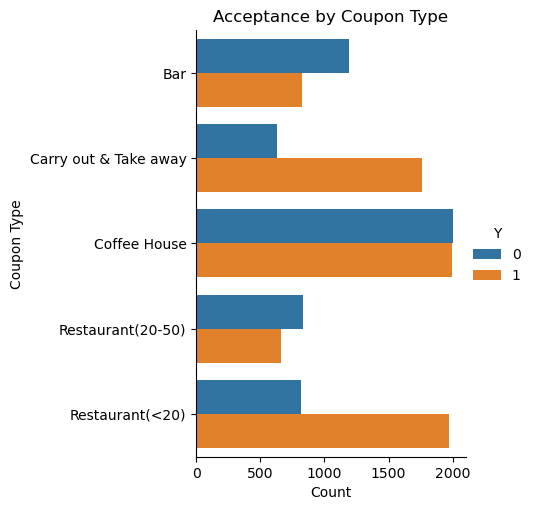

In [11]:
sns.catplot(data=coupon, kind='bar',
            y='coupon', x='count', hue='Y',
           )
plt.title('Acceptance by Coupon Type')
plt.xlabel('Count')
plt.ylabel('Coupon Type')
#plt.legend(title='Coupon Accepted', loc='upper right', labels=['No', 'Yes'])

#### 6. Use a histogram to visualize the temperature column.

In [12]:
temps = (data
         .groupby(['temperature'])['Y']
         .value_counts(ascending=True)
         .reset_index()
        )
temps

,temperature,Y,count
0,30,0,1086
1,30,1,1230
2,55,0,1779
3,55,1,2061
4,80,0,2609
5,80,1,3919


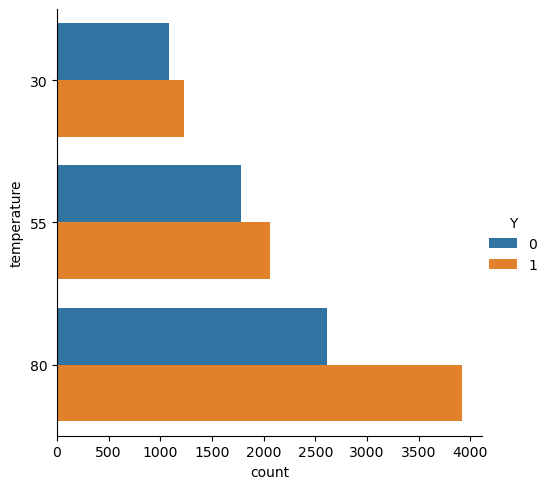

In [13]:
sns.catplot(data=temps, kind='bar', orient='h',
            y='temperature', x='count', hue='Y'
           )

<Axes: xlabel='temperature', ylabel='Count'>

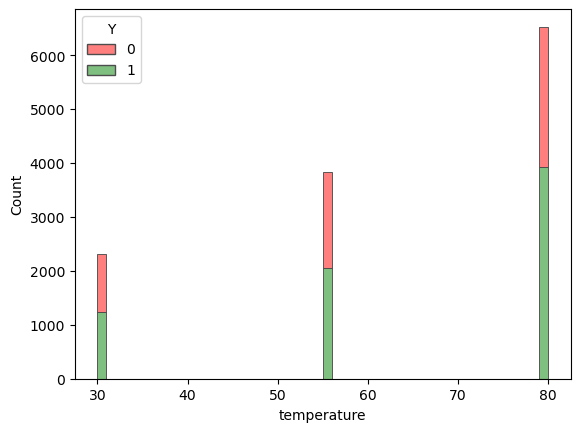

In [14]:
sns.histplot(
    data=data,
    x="temperature", hue="Y",
    palette=['red','green'], alpha=0.5,
    multiple="stack",
    #halign='center',
    edgecolor=".3",
    #linewidth=.5,
    bins=50
)

**Does the Weather have any influence along with Temperature?**

In [15]:
temps = (data
         .groupby(['temperature','weather'])['Y']
         .value_counts(ascending=True)
         .reset_index()
        )
#temps

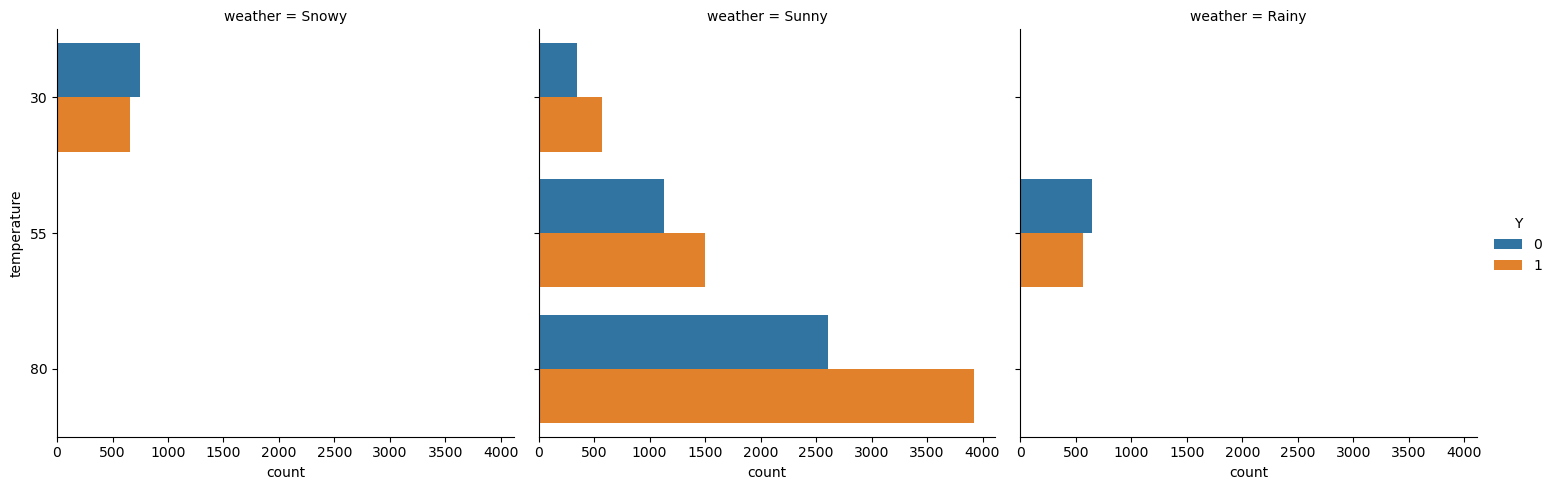

In [16]:
sns.catplot(data=temps, kind='bar', orient='h',
            y='temperature', x='count', hue='Y', col='weather'
           )

**Investigating the Bar Coupons**

Now, we will lead you through an exploration of just the bar related coupons.  

1. Create a new `DataFrame` that contains just the bar coupons.


In [17]:
coupons_bar = data[data['coupon'] == 'Bar']
coupons_bar.head(2)

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
9,No Urgent Place,Kid(s),Sunny,80,10AM,Bar,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
13,Home,Alone,Sunny,55,6PM,Bar,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,1,0,1


In [18]:
coupons_bar['Bar'] = coupons_bar[['Bar']].fillna(value='Missing')

2. What proportion of bar coupons were accepted?

In [19]:
acceptance_rate_bar = (coupons_bar[coupons_bar['Y'] == 1].shape[0] / coupons_bar.shape[0]) * 100
print('Bar Coupon Acceptance Rate: {:.2f}%'.format(acceptance_rate_bar))

Bar Coupon Acceptance Rate: 41.00%


In [20]:
# Bar acceptance buckets by percent
dfp = (coupons_bar
      .groupby('Bar')['Y']
      .value_counts(normalize=True)
      .mul(100)
      .rename('percent')
      .reset_index()
      .round(2)
)
#dfp

Text(36.30377083333334, 0.5, 'Acceptance breakdown for each bucket (Percent)')

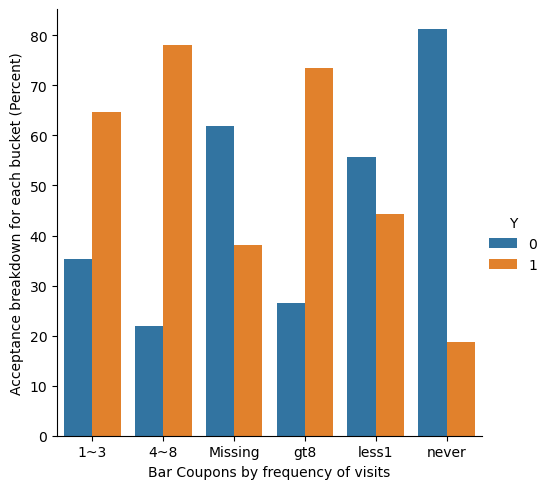

In [21]:
sns.catplot(data=dfp, kind='bar',
            x='Bar', y='percent',
            hue='Y')
plt.xlabel('Bar Coupons by frequency of visits')
plt.ylabel('Acceptance breakdown for each bucket (Percent)')

3. Compare the acceptance rate between those who went to a bar 3 or fewer times a month to those who went more.


In [22]:
# Bar acceptance buckets by count
dfc = (coupons_bar
      .groupby('Bar')['Y']
      .value_counts()
      .reset_index()
)
#dfc

Text(37.34880208333334, 0.5, 'Acceptance breakdown for each bucket (Count)')

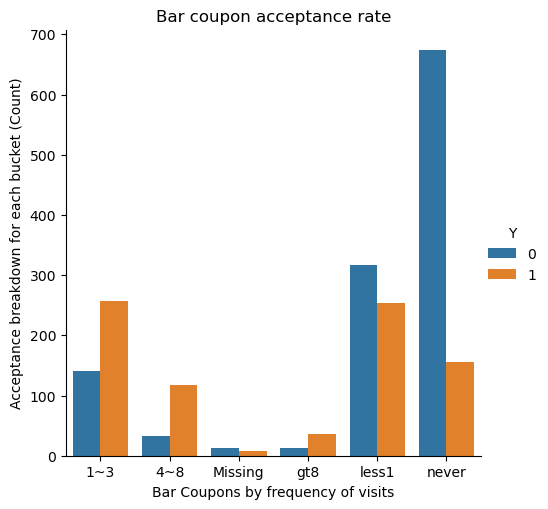

In [23]:
sns.catplot(data=dfc, kind='bar',
            x='Bar', y='count',
            hue='Y')
plt.title('Bar coupon acceptance rate')
plt.xlabel('Bar Coupons by frequency of visits')
plt.ylabel('Acceptance breakdown for each bucket (Count)')

4. Compare the acceptance rate between drivers who go to a bar more than once a month and are over the age of 25 to the all others.  Is there a difference?


5. Use the same process to compare the acceptance rate between drivers who go to bars more than once a month and had passengers that were not a kid and had occupations other than farming, fishing, or forestry. 


6. Compare the acceptance rates between those drivers who:

- go to bars more than once a month, had passengers that were not a kid, and were not widowed *OR*
- go to bars more than once a month and are under the age of 30 *OR*
- go to cheap restaurants more than 4 times a month and income is less than 50K. 



7.  Based on these observations, what do you hypothesize about drivers who accepted the bar coupons?

### Independent Investigation

Using the bar coupon example as motivation, you are to explore one of the other coupon groups and try to determine the characteristics of passengers who accept the coupons.  